## Init TF

In [1]:
import numpy as np
import tensorflow as tf
#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
from utils import *
import tensorflow_probability as tfp
import time
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
# from numba import cuda #gpu library used to clear gpu memory after each trial

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

Autosaving every 180 seconds


## ICET3D

In [37]:
from ICET3D import ICET3D

settings.embedWindow(backend='ipyvtk', verbose = True)

plt = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud1 = velo1[:,:3]
cloud1_tensor = tf.convert_to_tensor(cloud1, np.float32)
velo2 = dataset.get_velo(2) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud2 = velo2[:,:3]
cloud2_tensor = tf.convert_to_tensor(cloud2, np.float32)

f = tf.constant([10,10,1]) #fidelity in x, y, z # < 5s
lim = tf.constant([-100.,100.,-100.,100.,-10.,10.]) #needs to encompass every point
nc = 15
mnp = 5
npts = 100000
D = False #draw sim
DG = False #draw grid
DE = True #draw ellipsoids
DC = True #draw correspondences
TD = True #use test dataset

start = time.time()
# #use whole point set
# #---------------------------------------------------------------------------------
# f = tf.constant([50,50,2]) #fidelity in x, y, z # < 5s
# lim = tf.constant([-100.,100.,-100.,100.,-10.,10.]) #needs to encompass every point
# Q, x_hist = ICET3D(cloud1_tensor[:npts], cloud2_tensor[:npts], plt, bounds = lim, 
#            fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG, 
#            draw_ell = DE, draw_corr = DC)
# #---------------------------------------------------------------------------------

#just consider small section of image where there are easily identifiable features:
#----------------------------------------------------------------------------------
limtest = tf.constant([-20.,0.,-20.,0.,-1.5,1.5])
f = tf.constant([20,20,20])
# cloud1_tensor = tf.squeeze(tf.gather(cloud1_tensor, tf.where( (cloud1_tensor[:,0] > limtest[0]))))	#only works one cond at a time
cloud1_tensor = tf.squeeze(tf.gather(cloud1_tensor, tf.where( tf.math.reduce_all(tf.concat( (
	(cloud1_tensor[:,0] > limtest[0])[:,None], 
	(cloud1_tensor[:,0] < limtest[1])[:,None], 
	(cloud1_tensor[:,1] > limtest[2])[:,None], 
	(cloud1_tensor[:,1] < limtest[3])[:,None],
	(cloud1_tensor[:,2] > limtest[4])[:,None], 
	(cloud1_tensor[:,2] < limtest[5])[:,None],
	), axis = 1 ), axis = 1))))
cloud2_tensor = tf.squeeze(tf.gather(cloud2_tensor, tf.where( tf.math.reduce_all(tf.concat( (
	(cloud2_tensor[:,0] > limtest[0])[:,None], 
	(cloud2_tensor[:,0] < limtest[1])[:,None], 
	(cloud2_tensor[:,1] > limtest[2])[:,None], 
	(cloud2_tensor[:,1] < limtest[3])[:,None],
	(cloud2_tensor[:,2] > limtest[4])[:,None], 
	(cloud2_tensor[:,2] < limtest[5])[:,None],), axis = 1 ), axis = 1))))
Q, x_hist = ICET3D(cloud1_tensor, cloud2_tensor, plt, bounds = limtest, 
           fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG,
           draw_ell = DE, draw_corr = DC, test_dataset = TD)
#----------------------------------------------------------------------------------
#NOTE: Out of Memory Error comes from too high fidelity/ pts in cloud tensor --> 100x100x2x120,000 > 2gb

print("took", time.time() - start, "seconds total")

# print(tf.sqrt(tf.math.abs(Q)))
ans = np.sqrt(Q.numpy())
print(ans[0,0], ans[1,1], ans[2,2])
ViewInteractiveWidget(plt.window)

tf.Tensor([44130     3], shape=(2,), dtype=int32)
took 0.11202502250671387 seconds with tensorflow

 shapes 
 tf.Tensor([5531    3], shape=(2,), dtype=int32) tf.Tensor([5531    3    3], shape=(3,), dtype=int32) tf.Tensor([273], shape=(1,), dtype=int32)
y0 tf.Tensor([254   3], shape=(2,), dtype=int32)
neg_mask, U 
 tf.Tensor([254   1   1], shape=(3,), dtype=int32) tf.Tensor([254   3   3], shape=(3,), dtype=int32)
0 -----------------
took 0.11346864700317383 seconds with tensorflow

 x 
 tf.Tensor([ 0.04875256 -3.0112088   0.3544351  -0.02604889  0.00959628 -0.01103695], shape=(6,), dtype=float32)
1 -----------------
took 0.11003398895263672 seconds with tensorflow

 x 
 tf.Tensor([ 0.91772616 -0.70699763  0.3494707   0.05536141 -0.01891927 -0.00690347], shape=(6,), dtype=float32)
2 -----------------
took 0.11102485656738281 seconds with tensorflow

 x 
 tf.Tensor([-2.0642576  -5.3982677   2.2505922  -0.0587888   0.04185021 -0.01438242], shape=(6,), dtype=float32)
3 -----------------
too

C:\Users\Derm\anaconda3\envs\robot\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

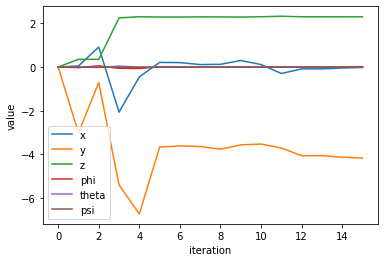

In [40]:
#display progression of solution values
from matplotlib import pyplot as plt
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.set_xlabel("iteration")
ax1.set_ylabel("value")

ax1.plot(x_hist.numpy())
ax1.legend(['x','y','z','phi','theta','psi'])
# ax1.plot(x_hist[:,3:].numpy())
# ax1.legend(['phi','theta','psi'])

In [23]:
a = tf.linspace(1.,10.,10)
print(a)
mask = tf.cast(tf.math.less(a, 4), tf.float32)
print(mask)
a = a*mask
print(a)

tf.Tensor([ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.], shape=(10,), dtype=float32)
tf.Tensor([1. 1. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
tf.Tensor([1. 2. 3. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [ ]:
#test - multiply a [6,6] tensor with a [N, 6, 3] tensor
# A = tf.eye(6)        #[6, 6]
# B = tf.ones([2,6,3]) #[2, 6, 3]
# print(tf.shape(tf.matmul(A,B))) #[2, 6, 3]

C = tf.ones([164, 6,3])
D = tf.ones([164,3])[:,:,None]
print(tf.shape(tf.matmul(C,D)))

In [ ]:
tf.math.greater(tf.ones(3), tf.constant([-1.,2.,3.]))

## Subdivide scan using NumPy

In [ ]:
## from vedo import *
from utils import *
import numpy as np
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti

settings.embedWindow(backend='ipyvtk', verbose = True) #was this

try:
    plt1.closeWindow()
    print("closed")
except:
    pass

plt1 = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)
# settings.useParallelProjection = True #makes view orthographic

## uncomment to use VOLPE dataset -----------------------------------------------------
# location = 'C:/Users/Derm/2021-03-10-16-43-50_Velodyne-VLP-16-Data_garminSignage.txt'
# cloud = np.loadtxt(open(location, "rb"), delimiter=",")
# cloud = cloud[~np.isnan(cloud).any(axis=1)] #remove all rows with NaN elements
## ------------------------------------------------------------------------------------

## uncomment to use KITTI dataset -----------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud = velo1[:,:3]
## ------------------------------------------------------------------------------------

# make 2D sinusioal pattern (for debug) ------------------------------------------------
# cloud = np.random.randn(10000,3)
# cloud[:,0] += -50*cloud[:,1] + np.random.randn()*5
# cloud[:,1] += 5
# cloud[:,1] = cloud[:,1] * 3 + 10*np.random.randn() + np.sin(cloud[:,1]*5)*10
# cloud[:,2] += 0.5*cloud[:,1] - 10
##-------------------------------------------------------------------------------------

# f =np.array([200,200,40]) #fidelity in x, y, z #takes ~30s on my dsektop
# lim = np.array([-50,50,-50,50,-10,10])

f =np.array([100,100,2]) #fidelity in x, y, z # < 5s
lim = np.array([-100,100,-100,100,-10,10])

for _ in range(1):
#     cloud_partial = tf.gather(cloud,tf.cast((tf.linspace(1,100000,100)), tf.int32))
    cloud_partial = cloud
    mus, sigmas, sizes = subdivide_scan(cloud_partial,plt1, bounds = lim, fid = f, draw_grid = False, show_pc = True) 

# print("\n mus: \n", mus)
# print("\n sigmas: \n", sigmas, np.shape(sigmas))
    
ViewInteractiveWidget(plt1.window)

## Subdivide scan using TensorFlow

In [ ]:
## from vedo import *
from utils import *
import numpy as np
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti

settings.embedWindow(backend='ipyvtk', verbose = True) #was this

plt2 = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

## uncomment to use KITTI dataset -----------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud = velo1[:,:3]
cloud_tensor = tf.convert_to_tensor(cloud, np.float32)
# print(tf.shape(cloud))
## ------------------------------------------------------------------------------------

# # make 2D sinusioal motion (for debug) ------------------------------------------------
# cloud = np.random.randn(10000,3)
# cloud[:,0] += -50*cloud[:,1] + np.random.randn()*5
# cloud[:,1] += 5
# cloud[:,1] = cloud[:,1] * 3 + 10*np.random.randn() + np.sin(cloud[:,1]*5)*10
# cloud[:,2] += 0.5*cloud[:,1] - 10
# #-------------------------------------------------------------------------------------

f = tf.constant([100,100,2]) #fidelity in x, y, z # < 5s
lim = tf.constant([-100.,100.,-100.,100.,-10.,10.])
DRAW = True

for _ in range(1):
#     cloud_partial = tf.gather(cloud,tf.cast((tf.linspace(1,100000,30)), tf.int32))
    cloud_partial = cloud
    E = subdivide_scan_tf(cloud_partial, plt2, bounds = lim, fid = f, draw=DRAW, draw_grid = False, show_pc = 1) 
# print("\n points: \n", cloud_partial)

# mu = E[0]
# print("\n mu: \n",mu)

# sigma = E[1]
# print("\n sigma: \n", sigma)

# print(tf.transpose(sigma))
# print("\n sigma[:,:,1] \n", sigma[:,:,0])

# sig2 = tf.reshape(tf.transpose(sigma), (tf.shape(sigma)[1] ,3,3))
# print("reshaped sigma \n", sig2)

# shapes = E[2]
# print("\n shapes: \n", shapes)

# sigma = E[1]
# print(tf.shape(sigma),sigma[:,:,1])

# if DRAW:
ViewInteractiveWidget(plt2.window)


### kNN

In [ ]:
# a = tf.constant([1.,1.,1.]) #works ------------------------------
# print("\n a \n", a)

# b = tf.random.normal([10,3])
# print("\n b \n", b)

# dist = tf.reduce_sum(tf.math.squared_difference(a,b), axis = 1)
# ans = tf.where(dist == tf.math.reduce_min(dist))[0,0]
# print("\n ans \n", b[ans])
## -----------------------------------------------------------------

# batch input - not working yet ------------------------------------
a = tf.constant([[[1., 1., 1.]],
                 [[0., 0., 0.]],
                 [[0., 0., 0.]]])  
print("\n a \n", a)

b = tf.random.normal([10,3])
print("\n b \n", b)

# print(tf.gather(a,(0,1)))
# print(tf.math.subtract(a, b))
# print(tf.square(a-b))
dist = tf.math.reduce_sum( (tf.square( tf.math.subtract(a, b) ))  , axis = 2)
print("\n dist \n", dist)

ans = tf.where( tf.transpose(dist) ==tf.math.reduce_min(dist, axis = 1))
print("\n shortest dist \n", ans)

reordered = tf.argsort(ans[:,1], axis = 0)
print("\n reordered \n", tf.gather(ans,reordered))


### Create ragged tensor given row sizes

In [ ]:
sizes = tf.constant([1,2,8,4,5])

# dummy_vals would be (points_x - mu_x)
v = tf.random.uniform([tf.math.reduce_sum(sizes)])
dummy_vals = tf.RaggedTensor.from_row_lengths(v ,sizes) 
print(dummy_vals.to_tensor() - 1)
mask_test = tf.RaggedTensor.from_row_lengths(tf.ones(tf.math.reduce_sum(sizes)) ,sizes)
print(tf.transpose(mask_test.to_tensor()))
print((dummy_vals.to_tensor() -1) * mask_test.to_tensor())

## Unit Test R() and Jacobian

In [ ]:
n_hat = np.array([1,0,0])
theta =  0.1 #np.pi/6 #rad

rot_mat_simp = R_simp(n_hat, theta)
print(rot_mat_simp)
angs = np.array([theta,0 ,0])
rot_mat = R(angs)
print(rot_mat)

print(R2Euler(rot_mat))

p_point = np.array([1,1,1]).T

J = jacobian(angs, p_point)

d_rot_mat_simp = dR_simp(n_hat,theta)
# print(d_rot_mat_simp)

## Unit test R2Euler_tf and R_tf
#### Works with single axis roation
#### Works with vectoried input
#### Solution becomes ambiguious with mutliple axis inputs

In [ ]:
angs = tf.random.normal((3,1)) * tf.constant([[0.], [0.], [1.] ]) #single axis angle input
# angs = tf.Variable([[0.],[ np.pi/2],[ 0.]]) #vector input, multiple axis rotation
print("Input angs: \n", angs.numpy())
# print("R(angs): \n", R_tf(angs).numpy())
test1 = R2Euler_tf(R_tf(angs))
print("R2Euler_tf(R(angs)): \n", test1.numpy())
# test2 = R2Euler(R(angs[:,:2]))
# print(test2)

### Unit test tfp find bins

In [ ]:
c = tf.convert_to_tensor(cloud, np.float32)#[:100]
# print("c: \n", c.numpy())
startx = -100.
stopx = 100.
numx = 10
edgesx = tf.linspace(startx, stopx, numx)
xbins = tfp.stats.find_bins(c[:,0], edgesx)
print(xbins)
starty = -100.
stopy = 100.
numy = 10
edgesy = tf.linspace(starty, stopy, numy)
ybins = tfp.stats.find_bins(c[:,1], edgesy)
print(ybins)

min_num_pts = 1000

count = 0
E = []

for x in range(numx):
    for y in range(numy):
        #only do calculations if there are a sufficicently high number of points in the bin
        xin = tf.where(xbins == x)
        if tf.shape(xin)[0] > min_num_pts:
            if tf.shape(tf.where(tf.gather(ybins, xin) == y))[0] > min_num_pts: #repeat for y points at x coord
#                 print("working", x, y)
                count += 1
# print(xin)
# print(ybins)
print(count)

In [ ]:
test = tf.linspace(1,5,5)
print(test)
ans = tf.where(test < 4)
print("ans: \n",ans)
print("\n", tf.gather(test, ans))


## Inline volumetric rendering using ipyvolume

In [ ]:
#simple demo
import ipyvolume
ds = ipyvolume.datasets.aquariusA2.fetch()
short = ds.data[:,:,:]
ipyvolume.quickvolshow(short, lighting=True)

In [ ]:
ans = np.linspace(1,12,8)
ans[2] = 0
print(ans)

test = ans[ans < 10]
print(test)
np.shape(test)[0]

print(np.median(test[:3]))

In [ ]:
tes = tf.random.normal([3,3])
print(tes)
print(tf.reverse(tes, axis = [1]))

In [ ]:
# a = tf.reshape([10.,10.,2.], (3,1))
# print(type(a))
# t = tf.Tensor(a, dtype = "float32")

a = tf.constant([2.1,2.,3.])
b = tf.constant([1.,2.,3.])
tf.tensordot(a,b, axes = 0)

In [ ]:
eye = tf.eye(3)
# print(j)
Jx = tf.constant([[1.], [2.], [3.]])
J = tf.concat([eye, Jx], axis = 1)
print(J)

### compare jacobian() and jacobian_tf()

In [ ]:
# print(tf.sin(1.))
start = time.time()
numiter = 1000
angs  = np.array([1.,0.1,0.1])
p_point = np.array([1.,2.,3.])
for _ in range(numiter):
    J = jacobian(angs, p_point);
print("took", time.time()-start, "seconds on CPU")
print(J)

In [ ]:
#TF is slower if we do them one by one BUT is waaay faster if we send them in all at once
start = time.time()
numiter = 1000
# angs = tf.random.normal((3,numiter))
angs = tf.constant([1.,2.,3.])
p_point = tf.random.normal((3,numiter))
J = jacobian_tf(p_point, angs);
print("took", time.time()-start, "seconds on GPU")
print(J)

### Testing subdividing cells without loop

In [ ]:
#Goal: given input tensor "cloud" and "bins" which contains all og and binned coordinates
#      subdivide and perform ops on "cloud" wihtout using any loops 

bins = tf.transpose(tf.constant([[2., 1., 3., 0., 2., 2., 3., 1., 0., 2.],
                                 [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                 [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]]))
cloud = bins + tf.random.normal(tf.shape(bins))*0.1
print("binned coordinate values: \n", bins)
# print(cloud)

#1d case (easy)
# q = tf.constant([1., 1., 2.]) 
# print(tf.squeeze(tf.gather(bins, ans))) #works for 1d, unsure of utility in 2d
#2d case (hard)
q = tf.constant([[[1., 1., 2.]],
                 [[0., 9., 9.]],
                 [[2., 0., 1.]],
                 [[7., 8., 9.]]])
print("\n cells of interest: \n",q)

idx = tf.equal(bins, q)
print(idx)
#ans outputs tensor of shape [N,2], where:
#  [[voxel number, index of [x,y,z] in cloud that corresponds to bin #],
#   [voxel number,index of [x,y,z] in cloud that corresponds to bin #]] ... 
loc = tf.where(tf.math.reduce_all(idx, axis = 2) == True)
print("\n loc: \n", loc)

#Need to "ungroup" so that we can fit_gaussian_tf() to each individual voxel...
s = tf.shape(loc)
group_ids, group_idx = tf.unique(loc[:, 0], out_idx=s.dtype)
num_groups = tf.reduce_max(group_idx) + 1
# print(group_ids, group_idx, num_groups)
sizes = tf.math.bincount(group_idx)
# print(sizes)

#replace <bins> here with <cloud> when done debugging
rag = tf.RaggedTensor.from_row_lengths(tf.gather(cloud, loc[:,1]), sizes) 
# print("ragged: \n", rag)

#Run on GPU as vectorized operation (WAAAAAY Faster) --
reg = tf.RaggedTensor.to_tensor(rag)
print("\n regular tensor: \n", reg)
mu, sigma = fit_gaussian_tf(reg)
print("mu: \n", mu)
print("sigma: \n", sigma)
#------------------------------------------------------- 

# # works but uses loop (runs on CPU -> slow) -----------
# A =  tf.data.Dataset.from_tensor_slices(rag)
# mus = []
# sigmas = []
# for i in range(len(A)):
#     mu, sigma = fit_gaussian_tf(rag[i])
#     mus.append(mu)
#     sigmas.append(sigma)
# print(mus, sigmas)
# #------------------------------------------------------

### Find "loc" more efficiently than using tf.where

In [ ]:
print("binned points: \n", bins)
print("\nbins to place them: \n",q)

# #SUPER inefficient 
# for i in range(tf.shape(bins)[0]):
#     for j in range(tf.shape(q)[0]):
#         if tf.reduce_all(bins[i] == q[j]):
#             print(j,i)
#             try:
#                 loc2 = tf.concat((loc2, tf.constant([[j,i]])), axis = 0)
#             except:
#                 loc2 = tf.constant([[j,i]])
# print("\n loc \n",loc2)
# loc2 = None

testidx = tf.where(bins == q[1])
print(testidx)
    
print("\n goal is to get this: \n",loc)

### remove zero rows from 3d tensor

In [ ]:
bins2 = tf.transpose(tf.constant([[[2., 9., 3., 0., 2., 2., 3., 1., 0., 2.], #x
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]], 
                                  
                                  [[2., 1., 3., 0., 2., 2., 3., 1., 0., 2.], #y
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]],
                                  
                                  [[2., 1., 3., 1., 2., 2., 3., 1., 0., 2.], #z
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]]]))

print(bins2[:2])
print(bins2[:,:,0])
#need to AVERAGE point locations PER AXIS, PER BIN
#   Ignore SPECIFIC POINTS where XYZ are ALL ZERO
idx = tf.math.not_equal(bins2[:,:,0], tf.constant([0.,0.,0.]))
print(idx[:2])
mask = tf.where(tf.math.reduce_any(idx, axis = 2) == True)
print("\n mask: \n", mask[:6]) #correct(?)
# print(tf.gather(bins,mask))

nonzero = tf.gather(bins,[0,0,0])
print("\n nonzero elements: \n", nonzero)

### Generate 2D tensor with all permutations (:n1, :n2, :n3)

In [ ]:
fida = 2 
fidb = 4
fidc = 1

a = tf.linspace(0,fida-1,fida)[:,None]
b = tf.linspace(0,fidb-1,fidb)[:,None]
c = tf.linspace(0,fidc-1,fidc)[:,None]

ansa = tf.tile(a, [fidb*fidc, 1])
ansb = tf.tile(tf.reshape(tf.tile(b, [1,fida]), [-1,1] ), [(fidc), 1])
ansc = tf.reshape(tf.tile(c, [1,fida*fidb]), [-1,1] )

q = tf.squeeze(tf.transpose(tf.Variable([ansa,ansb,ansc])))
print(q)

#GOAL- determine which voxel pt belongs in based on its coords
# pt = tf.constant([2,1,0])
pt = bins
print("\n pt:", pt, "\n")
num = tf.cast( ( pt[:,0] + fida*pt[:,1] + (fida*fidb)*pt[:,2] ), tf.int32)
print("\n", num, "\n")
# print(q[num])

ans = tf.concat((num[:,None], tf.cast(tf.linspace(0, tf.shape(pt)[0], tf.shape(pt)[0]  )[:,None],
                                      dtype = tf.int32) ), axis = 1 )
print(ans)


### Calculate covariance of 3d tensors with multiple voxels. Ignore zeros.

In [ ]:
a = tf.random.normal(shape=(10, 2, 1))
b = tf.random.normal(shape=(10, 2, 1))*4
c = tf.random.normal(shape=(10, 2, 1))

d = tf.concat((a,b,c), axis = 2)
d = tf.concat((d, tf.zeros((10,2,3))), axis = 0)
print(d[:,1])

I = tf.sparse.eye(10,3)
print("\n Sparse Identity: \n", I)

cov = tfp.stats.covariance(d, sample_axis = 0, event_axis = 2)
print("\n covariance matrices: \n", cov[1])

print(sizes)


In [ ]:
print(tf.cast((tf.linspace(1,1000,100)), tf.int32))